#Stock Market Prediction For TCS (TATA Consultancy Services) Stocks

In [0]:
import pandas as pd
import numpy as np
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as pl
from pandas.plotting import scatter_matrix

##Stock market data capturing for TCS company

In [0]:
main_company = 'TCS.NS'

# Compare with similar company
similar_company = ['INFY.NS','LTI.NS']

In [358]:
# Define the date range
start = datetime.datetime(2016, 10, 4)
end = datetime.datetime(2019, 10, 4)

df = web.DataReader(main_company, 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-09-27,2085.199951,2051.399902,2085.000000,2056.149902,2046795.0,2056.149902
2019-09-30,2104.000000,2060.000000,2061.850098,2099.300049,2620039.0,2099.300049
2019-10-01,2095.949951,2039.699951,2095.949951,2059.949951,3342877.0,2059.949951
2019-10-03,2081.149902,2046.150024,2070.000000,2060.250000,2317618.0,2060.250000
2019-10-04,2087.949951,2054.949951,2060.600098,2079.350098,2163036.0,2079.350098


## Data mining for TCS's stocks data

In [0]:
# Calculating the rolling mean for observation
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

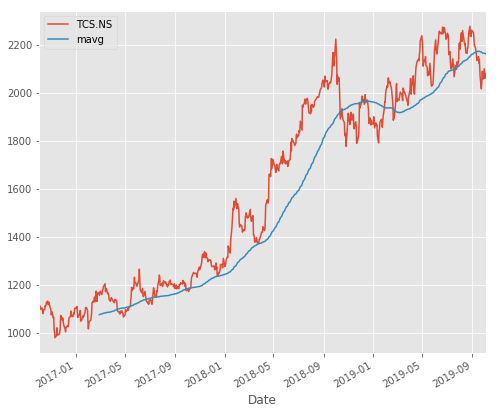

In [360]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label=main_company)
mavg.plot(label='mavg')
plt.legend()

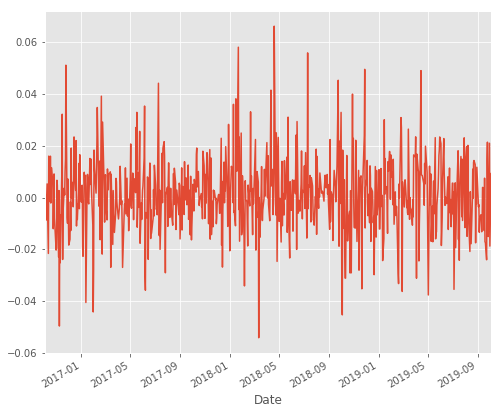

In [361]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

### Finding the Corelation among all the similar companies

In [362]:
dfcomp = web.DataReader([main_company, similar_company[0], similar_company[1]],'yahoo',start=start,end=end)['Adj Close']
dfcomp.tail()

Symbols,INFY.NS,LTI.NS,TCS.NS
Date,,,
2019-09-27,782.200012,1520.500000,2056.149902
2019-09-30,805.650024,1511.250000,2099.300049
2019-10-01,793.549988,1505.550049,2059.949951
2019-10-03,785.599976,1505.050049,2060.250000
2019-10-04,793.450012,1507.949951,2079.350098


In [363]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()
corr

Symbols,INFY.NS,LTI.NS,TCS.NS
Symbols,,,
INFY.NS,1.000000,0.219416,0.449331
LTI.NS,0.219416,1.000000,0.169951
TCS.NS,0.449331,0.169951,1.000000


Text(0, 0.5, 'Returns_INFY.NS')

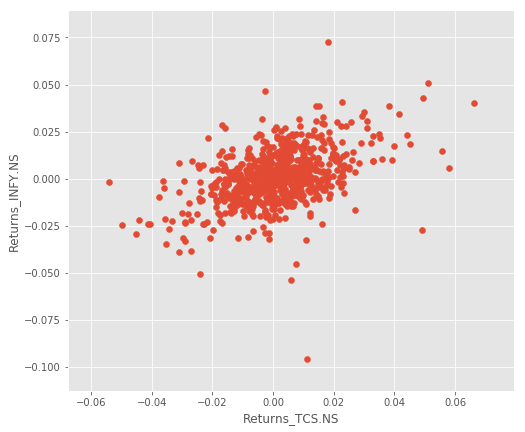

In [364]:
plt.scatter(retscomp[main_company], retscomp[similar_company[0]])
plt.xlabel('Returns_'+main_company)
plt.ylabel('Returns_'+similar_company[0])

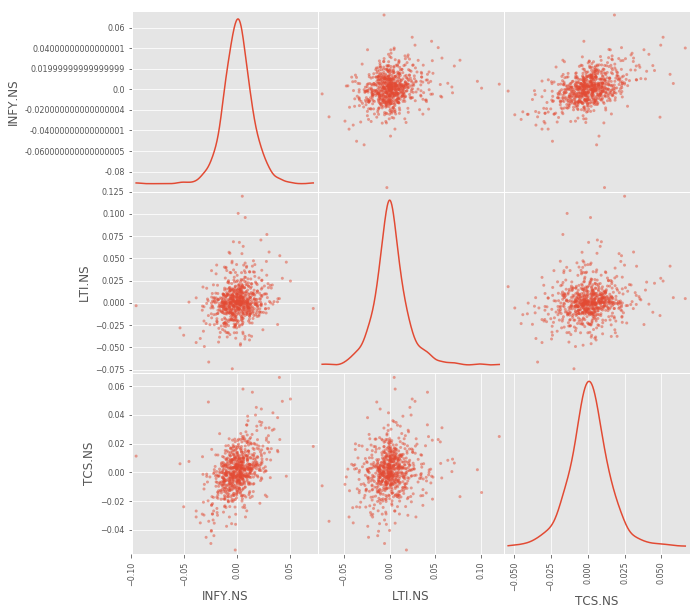

In [365]:
scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

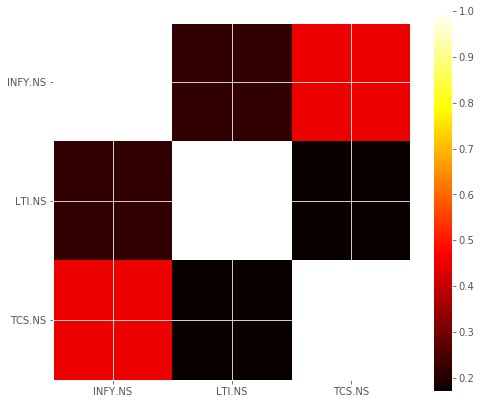

In [366]:
# Display Heatmap to identify the corelation between similar companies
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

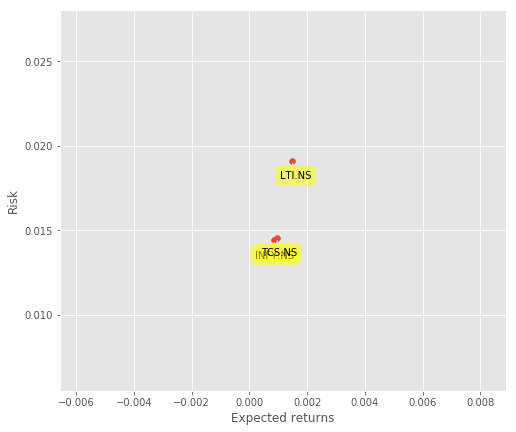

In [367]:
# Identify the risk on stock 
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

## Data Preprocessing

In [368]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-09-27,2056.149902,2046795.0,1.643851,-1.383698
2019-09-30,2099.300049,2620039.0,2.095937,1.816328
2019-10-01,2059.949951,3342877.0,2.730649,-1.717598
2019-10-03,2060.250000,2317618.0,1.698817,-0.471014
2019-10-04,2079.350098,2163036.0,1.587034,0.909929


In [0]:
import math
from sklearn import preprocessing

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]
y_lately = y[-forecast_out:]

## Prediction using Linear Models

In [0]:
from sklearn.linear_model import LinearRegression, Lasso, BayesianRidge, Ridge
from sklearn.preprocessing import PolynomialFeatures

In [371]:
X_train = X
y_train = y

# 1. Linear regression 
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# 2. Lasso - Linear Model
clflasso = Lasso(alpha=0.1)
clflasso.fit(X_train, y_train)

# 3. Bayesian Ridge - Linear Model
clfbr = BayesianRidge()
clfbr.fit(X_train, y_train)

# 4 Ridge - Linear Model
clfridge = Ridge(alpha=1.0)
clfridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [372]:
X_test = X_lately
y_test = y_lately

confidence_reg = clfreg.score(X_test, y_test)
confidence_lasso = clflasso.score(X_test,y_test)
confidence_br = clfbr.score(X_test,y_test)
confidence_ridge = clfridge.score(X_test, y_test)

print("confidencereg : ",confidence_reg)
print("confidence_lasso : ",confidence_lasso)
print("confidence_br : ",confidence_br)
print("confidence_ridge : ",confidence_ridge)

confidencereg :  0.934666158805443
confidence_lasso :  0.9388011317632636
confidence_br :  0.9366819618466231
confidence_ridge :  0.951168949057476


In [0]:
dfreg_lr = dfreg.copy()
dfreg_lasso = dfreg.copy()
dfreg_ridge = dfreg.copy()
dfreg_br = dfreg.copy()

noOfDaysData = 100

### 1. Prediction using Linear Regression 

In [374]:
forecast_set_linear_regression = clfreg.predict(X_lately)
dfreg_lr['Forecast_linear_regression'] =  np.nan
print(forecast_set_linear_regression)

[2047.98558817 2094.18802094 2092.66714942 2062.43859601 2100.80337673
 2063.21533393 2065.68016016 2083.5999788 ]


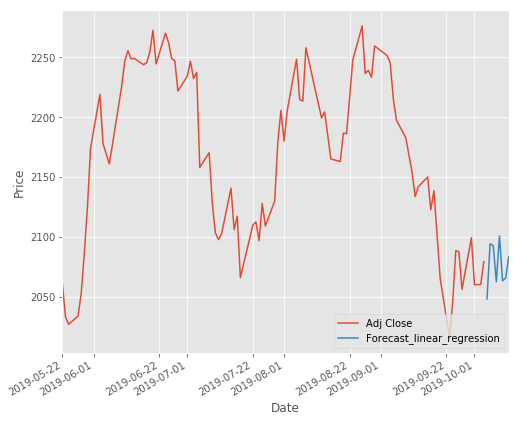

In [375]:
last_date = dfreg_lr.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_linear_regression:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg_lr.loc[next_date] = [np.nan for _ in range(len(dfreg_lr.columns)-1)]+[i]
dfreg_lr['Adj Close'].tail(noOfDaysData).plot()
dfreg_lr['Forecast_linear_regression'].tail(noOfDaysData).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### 2. Prediction Using Lasso - Linear model

In [376]:
forecast_set_lasso = clflasso.predict(X_lately)
dfreg_lasso['Forecast_lasso'] =  np.nan
print(forecast_set_lasso)

[2047.95358437 2094.02984861 2092.46515552 2062.19586695 2100.82163743
 2063.05219789 2065.49947678 2083.50366607]


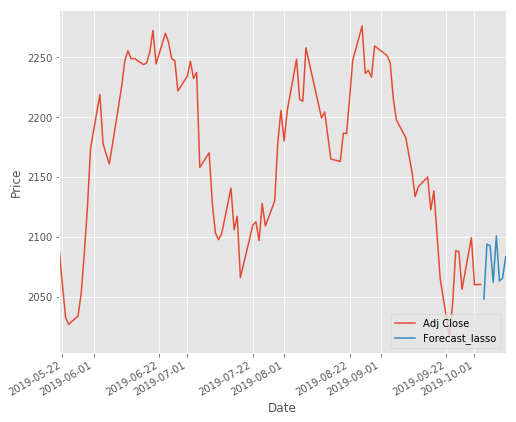

In [377]:
last_date = dfreg_lasso.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=0)

for i in forecast_set_lasso:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg_lasso.loc[next_date] = [np.nan for _ in range(len(dfreg_lasso.columns)-1)]+[i]
dfreg_lasso['Adj Close'].tail(noOfDaysData).plot()
dfreg_lasso['Forecast_lasso'].tail(noOfDaysData).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### 3. Prediction Using Bayesian Ridge - Linear model


In [378]:
forecast_set_bayesian_ridge = clfbr.predict(X_lately)
dfreg_br['Forecast_bayesian_ridge'] = np.nan
print(forecast_set_bayesian_ridge)

[2047.91508366 2094.10822157 2092.5904938  2062.36473859 2100.72222223
 2063.14511625 2065.60533824 2083.52078632]


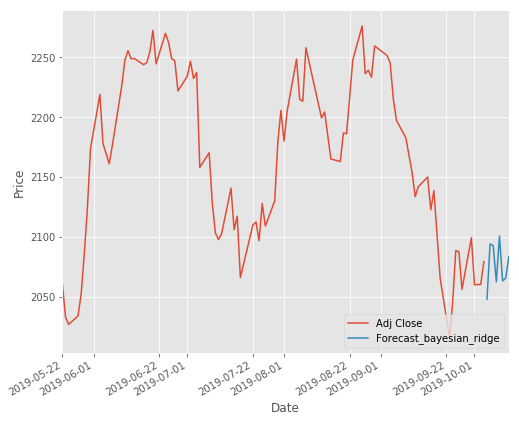

In [379]:
last_date = dfreg_br.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_bayesian_ridge:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg_br.loc[next_date] = [np.nan for _ in range(len(dfreg_br.columns)-1)]+[i]
dfreg_br['Adj Close'].tail(noOfDaysData).plot()
dfreg_br['Forecast_bayesian_ridge'].tail(noOfDaysData).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### 4. Prediction Using Ridge - Linear model

In [380]:
forecast_set_ridge = clfridge.predict(X_lately)
dfreg_ridge['Forecast_ridge'] =  np.nan
print(forecast_set_ridge)

[2047.36584782 2093.48659385 2091.99332729 2061.78938413 2100.09004398
 2062.59808372 2065.02247687 2082.90389521]


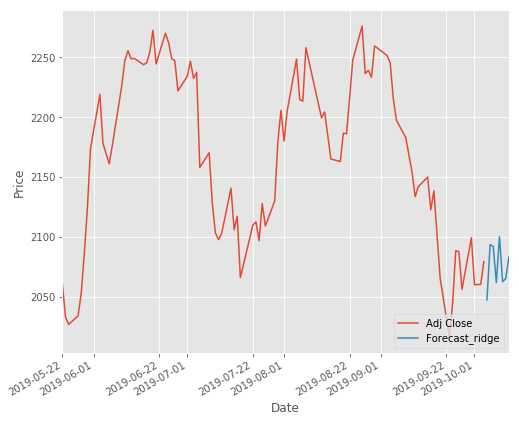

In [381]:
last_date = dfreg_ridge.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_ridge:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg_ridge.loc[next_date] = [np.nan for _ in range(len(dfreg_ridge.columns)-1)]+[i]
dfreg_ridge['Adj Close'].tail(noOfDaysData).plot()
dfreg_ridge['Forecast_ridge'].tail(noOfDaysData).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()